<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
import matplotlib
import statsmodels.tools.eval_measures as bias
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from mpl_toolkits.mplot3d import Axes3D # Axes3D import has side effects, it enables using projection='3d' in add_subplot
from math import ceil
from scipy import linalg
from os import listdir
from numpy.random import uniform, normal
from numpy.linalg import *
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.neighbors import KernelDensity
from statsmodels.nonparametric.kernel_regression import KernelReg

In [30]:
def dibuja_hist2(df,colour,name,Xlabel,Ylabel,title):
    CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff';
    plt.figure()
    df.hist(column=0, bins=25, grid=False, figsize=(7,4), color=colour, zorder=2, rwidth=0.9)
    plt.xticks(rotation=90)
    plt.xlabel(Xlabel)
    plt.ylabel(Ylabel)
    #https://stackoverflow.com/questions/9662995/matplotlib-change-title-and-colorbar-text-and-tick-colors/42020486
    mytitle = plt.title(title) # get the title property handler   #plt.getp(title_obj)  
    plt.setp(mytitle, color='#ff8000')                            # set the color of title
    myax = plt.axes()   # get the axis property handler           # plt.getp(myax) print its propieties
    myax.xaxis.label.set_color('#ff8000')
    myax.yaxis.label.set_color('#ff8000')
    myax.tick_params(colors='#ff8000', which='both')              # myax.spines['bottom'].set_color('yellow')
    plt.savefig(name, transparent=True)
    myax.spines['bottom'].set_color(LETRASNARA)
    myax.spines['top'   ].set_color(LETRASNARA) 
    myax.spines['right' ].set_color(LETRASNARA)
    myax.spines['left'  ].set_color(LETRASNARA)
    plt.show()                                                    # o plt.save_en_algún_formato()

In [31]:
def dibuja_lineas(x, ylist, labels, namefile, Xlabel, Ylabel, title):    
    #https://matplotlib.org/3.1.1/tutorials/introductory/usage.html#sphx-glr-tutorials-introductory-usage-py
    CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff';
    name = 'fig_t7_4'
    colors     = [CYAN,'r',LILA,VERDE,AZUL,'b','g']
    markers    = ['o','o','o','o','o','o','o']
    linestyles = ['--','-','--','-.','-.',':',':']
    fig, ax = plt.subplots(figsize=(7,6))

    for i in range(len(ylist)):
        plt.plot(x, ylist[i], linestyle=linestyles[i], marker=markers[i], label=labels[i], color=colors[i])

    plt.gcf().set_size_inches(8, 5)
    plt.xlabel(Xlabel,fontsize='large',color = LETRASNARA)
    plt.ylabel(Ylabel,fontsize='large',color = LETRASNARA)
    plt.title(title  ,fontsize='x-large',color = LETRASNARA)
    plt.legend(fontsize='large')
    plt.tick_params(colors = LETRASNARA, which='both')
    ax.spines['bottom'].set_color(LETRASNARA)
    ax.spines['top'   ].set_color(LETRASNARA) 
    ax.spines['right' ].set_color(LETRASNARA)
    ax.spines['left'  ].set_color(LETRASNARA)
    plt.savefig(namefile, transparent=True)
    plt.show()

In [32]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

Esta función calcula los pesos de los puntos $x_i\in\mathcal{Rp}$ del vecindario alrededor del punto $x_o\in\mathcal{Rp}$. Se da mayor peso a las puntos $x_i$ mas cercanos al punto $x_o$ y menos peso a las observaciones más lejanas utilizando un kernel que asigna importancia a cada uno de los k vecinos de $x_i$ según su distancia a $x_o$.

In [33]:
# Calcula los pesos y regresa una matriz diagonal con los pesos
def get_weight_exp(xo, X, k): 
## k    : tamanio del vecindario (bandwidth)
## X    : Regresores
## xo   : punto donde se desea hacer la predicción.

    n = X.shape[0]             ## numero de datos
    weight = np.mat(np.eye(n)) ## Matriz de pesos identidad W.
    
  # Cálculo de pesos para todos los datos de entrenamiento xi.
    for i in range(n): 
        xi = X[i] 
        d = (-2 * k * k) 
        weight[i, i] = np.exp(np.dot((xi-xo), (xi-xo).T)/d) 
        
    return weight

A continuación estimamos los coeficientes de regresión `β = (Xt W(xo) X)^{-1}) (Xt W Y)` con la matrix de pesos `W`.

In [34]:
def local_regression(X,W,Xo):
    # W     : Matriz diagonal de pesos
    # X     : Regresores
    # xo    : punto donde se desea hacer la predicción.
    Xt = X.T  # Calcula transpuesta de X
    A = np.matmul(Xt, np.matmul(W,X)) 
    A = np.linalg.inv(A)   # Calcula inversa de A
    B = np.matmul(Xt, np.matmul(W,Y)) 
    beta = np.matmul(A,B)
    prediccion = np.matmul(Xo,beta)
    return prediccion

A continuación haremos la comparación de resultados de regresión para datos de demanda eléctrica. La variable independiente `X` serán los datos de demanda del día anterior, y los datos independiente `Y` serán los datos de días con una mayor correlación con `X`. En esta sección, aplicaremos regresión lineal múltiple con multiples regresores `X`. Los datos usados en esta sección están disponibles en [demanda.csv](https://drive.google.com/file/d/1KpY2p4bfVEwGRh5tJjMx9QpH6SEwrUwH/view?usp=sharing)

## Muestreo **bootstrap** en estimación de error en la predicción de demanda eléctrica usando regresión líneal múltiple

In [35]:
df  = pd.read_csv('demanda.csv')
X   = pd.DataFrame(df[['X1','X2']]).to_numpy()
X   = pd.DataFrame(df[['X0','X1','X2','X3','X4','X5','X6','X7','X8','X9']]).to_numpy()
Y   = pd.DataFrame(df[['Y']]).to_numpy()

A continuación se calcula un modelo de regresión lineal múltiple para una de las muestras `X_train` elegidas aleatoriamente un 50% de datos del total del conjunto `X`. Los datos de error (MAE) de todas las réplicas del muestreo aleatorio se guardan en la lista `bootstrap_ols`.

Evaluación del desempeño del bootstrap variando tamaño de las muestra y número de muestreos aleatorios (repeticiones).

[[0    119.541852
dtype: float64, 0    119.622952
dtype: float64, 0    119.315508
dtype: float64, 0    118.954495
dtype: float64, 0    119.178212
dtype: float64, 0    118.622179
dtype: float64, 0    117.51659
dtype: float64, 0    116.293167
dtype: float64, 0    111.009939
dtype: float64], [0    119.449017
dtype: float64, 0    119.438477
dtype: float64, 0    119.325077
dtype: float64, 0    119.048971
dtype: float64, 0    118.503469
dtype: float64, 0    118.183266
dtype: float64, 0    117.384001
dtype: float64, 0    116.105434
dtype: float64, 0    110.483649
dtype: float64], [0    119.425138
dtype: float64, 0    119.330569
dtype: float64, 0    119.367105
dtype: float64, 0    119.169966
dtype: float64, 0    118.886718
dtype: float64, 0    118.589661
dtype: float64, 0    117.604618
dtype: float64, 0    115.859435
dtype: float64, 0    110.621982
dtype: float64], [0    119.537653
dtype: float64, 0    119.467796
dtype: float64, 0    119.370855
dtype: float64, 0    119.130536
dtype: float64, 0

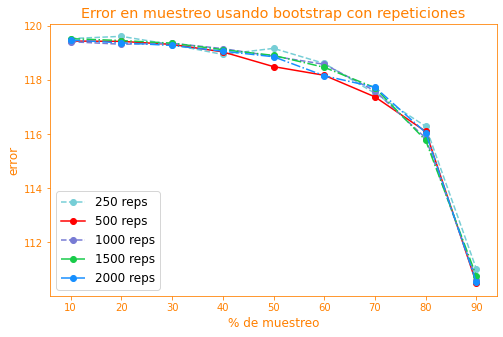

In [36]:
#Evaluación del desempeño del bootstrap variando tamaño de las muestra y número de muestreos aleatorios (repeticiones).
from numpy.ma.core import mean
percent   = [10,20,30,40,50,60,70,80,90] # porcentaje de muestreo
replicas  = [250,500,1000,1500,2000] # porcentaje de muestreo 1500,2000,2500,5000
test      = []
ylist     = []

for rep in replicas:
    mean      = []
    desv_up   = []
    desv_down = []
    for per in percent:
        bootstrap_ols= []
        for rep in range(rep):
            a = np.arange(0,X.shape[0])
            b = np.sort(np.random.choice(a, replace=False, size = int(len(a) * (per/100))))
            X_train = np.delete(X, b, axis = 0)
            Y_train = np.delete(Y, b, axis = 0)            
            olsmod = sm.OLS(Y_train, X_train)
            olsres = olsmod.fit()
            Y_pred = olsres.predict(X_train)  
            bootstrap_ols.append(mean_absolute_error(Y_train, Y_pred))
        dfb = pd.DataFrame((np.asarray(bootstrap_ols)).T)
        bootstrap_mean = dfb.mean(numeric_only = True)
        bootstrap_std = dfb.std(numeric_only   = True)        
        mean.append(bootstrap_mean)
        desv_up.append(bootstrap_mean   + bootstrap_std*2)
        desv_down.append(bootstrap_mean - bootstrap_std*2)
    test.append(mean)

labels   = ['250 reps','500 reps','1000 reps','1500 reps','2000 reps']
Xlabel   = '% de muestreo'
Ylabel   = 'error'
title    = "Error en muestreo usando bootstrap con repeticiones"
namefile = 'fig_t7_4'
print(test)
dibuja_lineas(percent, test, labels, namefile, Xlabel, Ylabel, title)

[[0    122.360841
dtype: float64, 0    123.924347
dtype: float64, 0    124.936839
dtype: float64, 0    125.927041
dtype: float64, 0    127.498025
dtype: float64, 0    128.801946
dtype: float64, 0    130.37168
dtype: float64, 0    133.506644
dtype: float64, 0    136.026846
dtype: float64], [0    119.561492
dtype: float64, 0    119.413754
dtype: float64, 0    119.228991
dtype: float64, 0    119.17931
dtype: float64, 0    118.800137
dtype: float64, 0    118.271504
dtype: float64, 0    117.540055
dtype: float64, 0    116.152401
dtype: float64, 0    111.279734
dtype: float64], [0    116.762143
dtype: float64, 0    114.903162
dtype: float64, 0    113.521142
dtype: float64, 0    112.431579
dtype: float64, 0    110.10225
dtype: float64, 0    107.741061
dtype: float64, 0    104.708431
dtype: float64, 0    98.798158
dtype: float64, 0    86.532623
dtype: float64]]


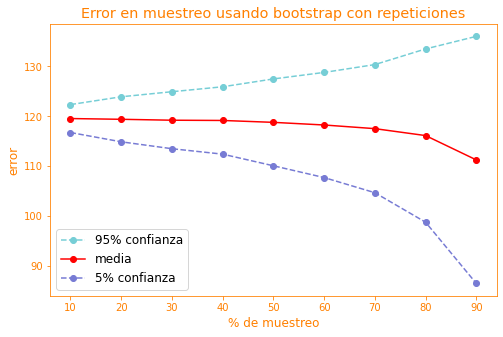

In [37]:
percent   = [10,20,30,40,50,60,70,80,90] # porcentaje de muestreo
replicas  = [500] # porcentaje de muestreo 1500,2000,2500,5000
test      = []
ylist     = []

for rep in replicas:
    mean      = []
    desv_up   = []
    desv_down = []
    for per in percent:
        bootstrap_ols= []
        for rep in range(rep):
            a = np.arange(0,X.shape[0])
            b = np.sort(np.random.choice(a, replace=False, size = int(len(a) * (per/100))))
            X_train = np.delete(X, b, axis = 0)
            Y_train = np.delete(Y, b, axis = 0)            
            olsmod = sm.OLS(Y_train, X_train)
            olsres = olsmod.fit()
            Y_pred = olsres.predict(X_train)  
            bootstrap_ols.append(mean_absolute_error(Y_train, Y_pred))
        dfb = pd.DataFrame((np.asarray(bootstrap_ols)).T)
        bootstrap_mean = dfb.mean(numeric_only = True)
        bootstrap_std = dfb.std(numeric_only   = True)        
        mean.append(bootstrap_mean)
        desv_up.append(bootstrap_mean   + bootstrap_std*2)
        desv_down.append(bootstrap_mean - bootstrap_std*2)
    test.append(desv_up)
    test.append(mean)
    test.append(desv_down)

labels   = ['95% confianza','media','5% confianza']
Xlabel   = '% de muestreo'
Ylabel   = 'error'
title    = "Error en muestreo usando bootstrap con repeticiones"
namefile = 'fig_t7_5'
print(test)
dibuja_lineas(percent, test, labels, namefile, Xlabel, Ylabel, title)

## Muestreo **cross-validation** en estimación de error en la predicción de demanda eléctrica usando regresión líneal múltiple
En esta función se calcula un modelo de regresión lineal múltiple para cada una de las una de las muestras `X_test` extraidas del total del conjunto de entrenamiento `X_train`. Los datos de error del muestreo cross-validation se guardan en la lista cross_ols.

576


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

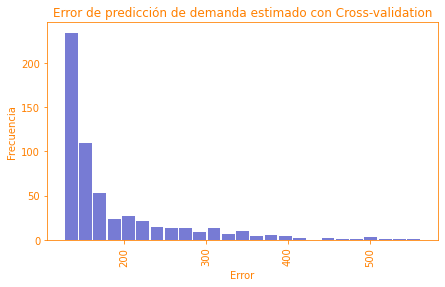

0    184.102077
dtype: float64
0    76.380279
dtype: float64


In [38]:
cross_ols_fx = []
nblocks    = 100
nblocks    = X.shape[0] 
print(X.shape[0] )
size = int( X.shape[0] / nblocks)
intervals = np.arange(size, X.shape[0], size)

for i in intervals:  
    a = np.arange(0,X.shape[0])
    b = np.arange(i-size,i)
    c = np.sort(np.setdiff1d(a, b)) #El complemento del conjunto seleccionado
    X_test  = np.delete(X, b, axis = 0)
    Y_test  = np.delete(Y, b, axis = 0)    
    X_train = np.delete(X, c, axis = 0)
    Y_train = np.delete(Y, c, axis = 0)

    olsmod  = sm.OLS(Y_train, X_train)
    olsres  = olsmod.fit()
    Y_pred  = olsres.predict(X_test)  
    error = abs(Y_test - Y_pred)
    cross_ols_fx.append(mean_absolute_error(Y_test,Y_pred))

dfb = pd.DataFrame((np.asarray(cross_ols_fx)).T)
cross_mean_fx = dfb.mean(numeric_only = True)
cross_std_fx = dfb.std(numeric_only = True)
dibuja_hist2(dfb,colour='#777bd4',name='hist_t7_2.png',Xlabel="Error",Ylabel="Frecuencia",title="Error de predicción de demanda estimado con Cross-validation")
print(cross_mean_fx)
print(cross_std_fx)

Esta versión de cross-validation elige aleatoriamente el inicio de las muestras de prueba X_test

[  8  11  23  24  25  34  37  38  41  47  49  51  52  55  56  62  67  70
  72  80  87  90  91  92  95  96  99 103 105 106 110 120 121 122 123 125
 126 127 132 134 137 138 140 146 148 149 157 162 167 169 174 175 176 178
 179 188 189 192 193 194 199 203 206 216 219 221 223 226 227 228 231 234
 236 240 241 243 244 246 247 248 255 256 257 258 259 261 262 266 273 274
 277 280 281 290 300 301 313 317 319 328 330 339 340 342 344 348 350 354
 358 362 364 365 373 374 376 380 383 384 388 390 391 392 405 409 413 414
 417 422 425 431 433 434 436 440 446 448 451 457 458 462 464 465 466 468
 474 475 476 479 482 486 491 495 496 497 500 504 510 512 513 518 519 521
 525 528 529 533 535 536 543 546 548 549 558 562 563 565 566 567 568 575]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

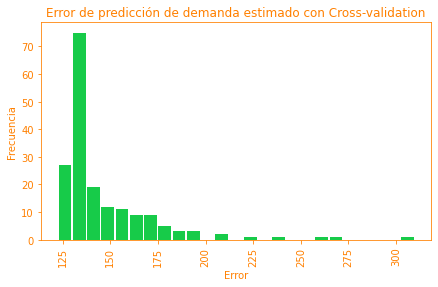

0    146.492008
dtype: float64
0    26.552486
dtype: float64


In [39]:
cross_ols = []
nblocks   = 300
size = int( X.shape[0] / nblocks)

replicas = 180
arr = np.sort(np.random.choice(a, replace=False, size = replicas))
print(arr)
for i in arr:

      a = np.arange(1,X.shape[0])
      b = np.arange(i-size,i)
      c = np.sort(np.setdiff1d(a, b)) #El complemento del conjunto seleccionado
      X_test  = np.delete(X, b, axis = 0)
      Y_test  = np.delete(Y, b, axis = 0)    
      X_train = np.delete(X, c, axis = 0)
      Y_train = np.delete(Y, c, axis = 0)

      olsmod  = sm.OLS(Y_train, X_train)
      olsres  = olsmod.fit()
      Y_pred  = olsres.predict(X_test)  
      error = abs(Y_test - Y_pred)
      cross_ols.append(mean_absolute_error(Y_test,Y_pred))

dfb = pd.DataFrame((np.asarray(cross_ols)).T)
cross_mean = dfb.mean(numeric_only = True)
cross_std = dfb.std(numeric_only = True)
dibuja_hist2(dfb,colour='#17cb49',name='hist_t7_3.png',Xlabel="Error",Ylabel="Frecuencia",title="Error de predicción de demanda estimado con Cross-validation")
print(cross_mean)
print(cross_std)